In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_PATH'] = '/media/gambino/students_workdir/ilias/miniconda3/envs/torch'
import torch
from models import PCAE, PointNetAE
from utils.helper_plotting import plot_latent_space, plot_latent_space_v2
import matplotlib.pyplot as plt
import numpy as np
import xarray
import anndata
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from geomloss import SamplesLoss
from utils.helper_utils import ChamferDistance
from scipy.stats import ttest_ind
import umap

In [2]:
real_dataset = xarray.load_dataset('/media/gambino/students_workdir/ilias/colonCancerPatient2_tiles/tile40_z3_dc_tacco_gene_expression_coords_masked.nc')

In [3]:
real_dataset.trans_coords.shape

(16195, 3, 450)

In [4]:
dataset = xarray.load_dataset('/media/gambino/students_workdir/ilias/all_simulated_data/gene_expression_coords_masked_dataset.nc')

In [5]:
np.random.seed(122)
shuffled_indices= np.random.permutation(dataset.index)
dataset_len = len(shuffled_indices)
train_indices = shuffled_indices[: int(0.8 * dataset_len)]
val_indices = shuffled_indices[int(0.8 * dataset_len) : int(0.9 * dataset_len)]
test_indices = shuffled_indices[int(0.9 * dataset_len) :]

In [6]:
train_dataset = dataset.isel(index=train_indices)
train = torch.Tensor(train_dataset.trans_coords.values)
val_dataset = dataset.isel(index=val_indices)
val = torch.Tensor(val_dataset.trans_coords.values)
test_dataset = dataset.isel(index=test_indices)
test = torch.Tensor(test_dataset.trans_coords.values)

In [7]:
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
DIR = '/media/gambino/students_workdir/ilias/code/notebooks/point_cloud_ae/trained_models/PointNetAE_15k_200p_geom_sinkhorn_50e_gene_expression_coords_masked_dataset.nc'
MODEL = PointNetAE

with open(f'{DIR}/log_dict.json','r') as f:
    log_dict = json.load(f)

with open(f'{DIR}/hyperparams.json','r') as f:
    hyperparams = json.load(f)

model = MODEL(hyperparams['k'], hyperparams['num_points'], loss_fn=hyperparams['loss_fn'])
model.to(device)
model.load_state_dict(torch.load(f'{DIR}/state_dict.pth'))

<All keys matched successfully>

In [10]:
hyperparams

{'training': False,
 'num_points': 200,
 'loss_fn': 'cd-t',
 'k': 15,
 'model': 'PointNetAE',
 'layers': ['STN2d(\n  (conv1): Conv1d(2, 64, kernel_size=(1,), stride=(1,))\n  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))\n  (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))\n  (fc1): Linear(in_features=1024, out_features=512, bias=True)\n  (fc2): Linear(in_features=512, out_features=256, bias=True)\n  (fc3): Linear(in_features=256, out_features=4, bias=True)\n  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (relu): ReLU()\n)',
  'Sequential(\n  (0): Conv1d(2, 64, kernel

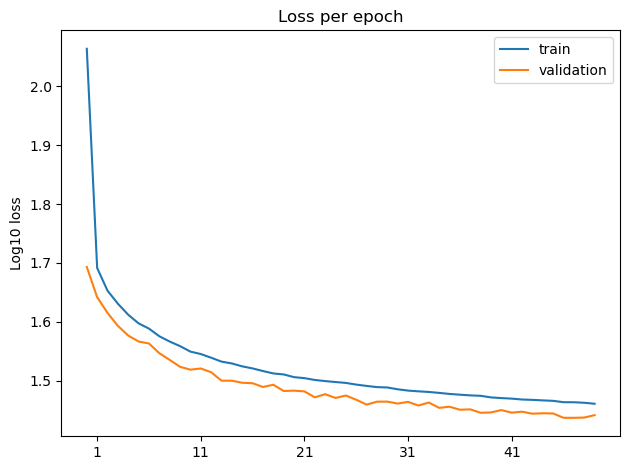

In [11]:
plt.clf()
plt.plot(np.log10(log_dict['train_reconstruction_loss_per_epoch']))
plt.plot(np.log10(log_dict['val_reconstruction_loss_per_epoch']))
plt.legend(labels=('train','validation'))
plt.title('Loss per epoch')
plt.ylabel('Log10 loss')
plt.xticks(range(1, len(log_dict['train_reconstruction_loss_per_epoch']),10))
plt.tight_layout()
plt.show()

Calculate reconstruction loss on unseen data

In [73]:
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=0.5, diameter=50, scaling=0.2, debias=False, backend='online')
cd_p = ChamferDistance(variant='cd-p')
cd_t = ChamferDistance(variant='cd-t')

losses_dict = {'sinkhorn':np.array([]), 'cd-p':np.array([]), 'cd-t':np.array([])}
with torch.no_grad():
    model.eval()
    test_loader = torch.utils.data.DataLoader(dataset=torch.Tensor(real_dataset.trans_coords.values),
                                                batch_size=256,
                                                num_workers=2,
                                                shuffle=False,
                                                drop_last=False)
    for in_feat in test_loader:
        features = in_feat.to(device)
        _,decoded = model(features)
        # decoded = torch.Tensor(real_dataset.trans_coords.values)[torch.randperm(256),:2].to(device)
        features, mask = torch.split(features, [2,1] ,dim=1)
        losses = torch.stack([cd_p(single_decoded.unsqueeze(0),\
                                single_feature[:,:torch.sum(single_mask, dtype=torch.int16)].unsqueeze(0))\
                                for single_feature, single_decoded, single_mask in zip(features, decoded, mask)])
        losses_dict['cd-p'] = np.append(losses_dict['cd-p'],losses.detach().cpu().numpy())

        losses = torch.stack([cd_t(single_decoded.unsqueeze(0),\
                                single_feature[:,:torch.sum(single_mask, dtype=torch.int16)].unsqueeze(0))\
                                for single_feature, single_decoded, single_mask in zip(features, decoded, mask)])

        losses_dict['cd-t'] = np.append(losses_dict['cd-t'],losses.detach().cpu().numpy())

        features = features.swapaxes(1,2).contiguous()
        decoded = decoded.swapaxes(1,2).contiguous()
        losses = torch.stack([sinkhorn(single_decoded[:torch.argwhere(single_mask).size(0)], single_feature[:torch.argwhere(single_mask).size(0)])\
                                                    for single_feature, single_decoded, single_mask in zip(features, decoded, mask)])
        losses_dict['sinkhorn'] = np.append(losses_dict['sinkhorn'],losses.detach().cpu().numpy())


In [71]:
np.mean(losses_dict['sinkhorn']), np.std(losses_dict['sinkhorn'])

(45.8952534468316, 25.13097165407573)

In [72]:
random_real_losses = losses_dict

In [89]:
res = ttest_ind(losses_dict['cd-p'],random_real_losses['cd-p'])
res.pvalue

0.0

Reconstructions

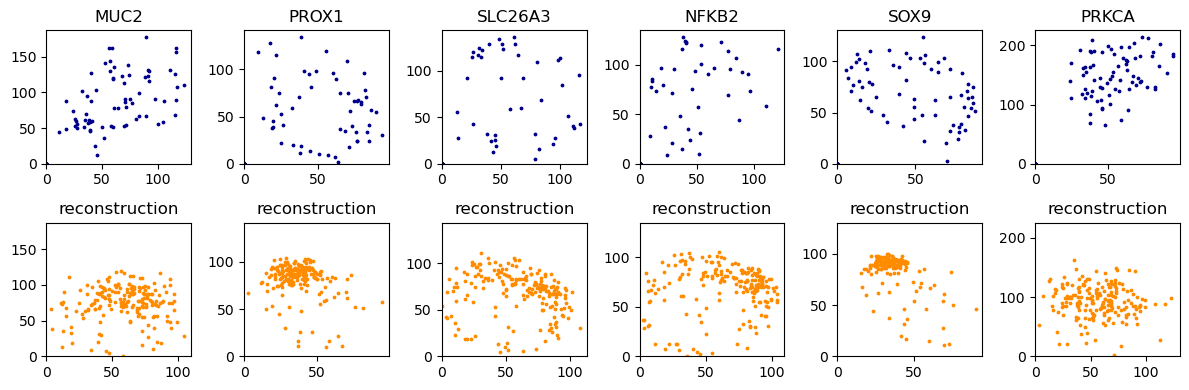

In [50]:
plt.clf()
plt.close()
fig, axs = plt.subplots(2,6)
fig.set_size_inches(12,4)
model.eval()
examples = np.unique(real_dataset['gene'],return_index=True)[1]
np.random.shuffle(examples)
with torch.no_grad():
    for ax,i in zip(axs.swapaxes(0,1), examples):
        in_feat = torch.Tensor(real_dataset.trans_coords.values)[i:i+1]
        _,out = model(in_feat.to(device))
        ax[0].scatter(in_feat[0,1], in_feat[0,0],
                    marker='o', s=3, c='darkblue')
        ax[0].set_title(f"{real_dataset['gene'][i].to_numpy()}", loc='center')
        ax[0].set_xlim(left=0)
        ax[0].set_ylim(bottom=0)
        ax[0].sharey(ax[1])

        out = out.detach().cpu()
        ax[1].scatter(out[0,1],out[0,0],
                    marker='o', s=3, c='darkorange')
        ax[1].set_title('reconstruction', loc='center')
        ax[1].set_xlim(left=0)
        ax[1].set_ylim(bottom=0)

fig.tight_layout()
plt.show()

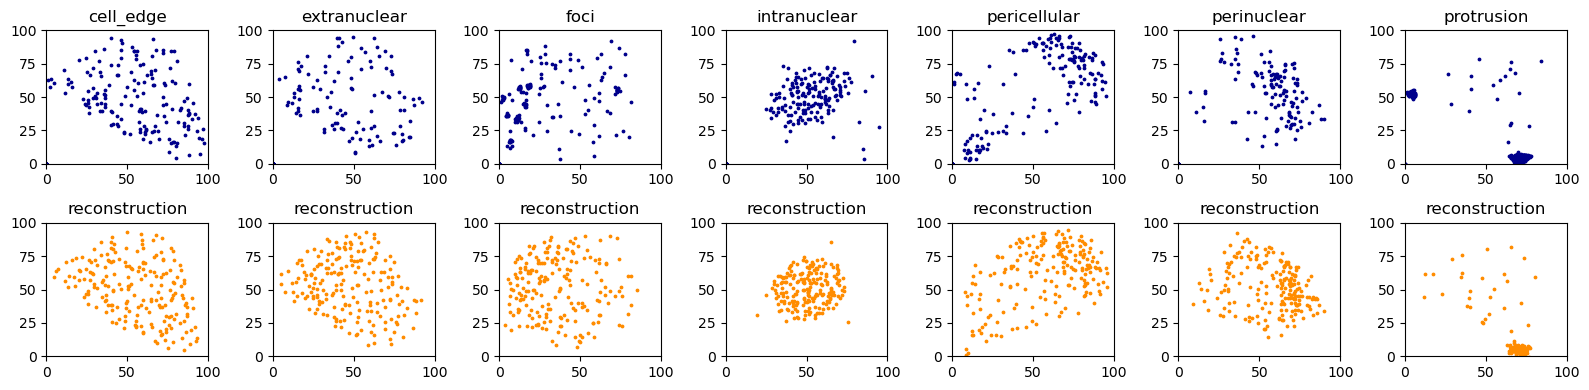

In [11]:
plt.clf()
plt.close()
fig, axs = plt.subplots(2,len(np.unique(test_dataset.pattern))-1)
fig.set_size_inches(16,4)
model.eval()
examples = np.unique(test_dataset.pattern,return_index=True)[1]
with torch.no_grad():
    for ax,i in zip(axs.swapaxes(0,1), examples):
        in_feat = test[i:i+1]
        _,out = model(in_feat.to(device))
        ax[0].scatter(in_feat[0,1], in_feat[0,0],
                    marker='o', s=3, c='darkblue')
        ax[0].set_title(f"{test_dataset.index.metadata['pattern'][i].to_numpy()}", loc='center')
        ax[0].set_xlim(0,100)
        ax[0].set_ylim(0,100)
        ax[0].sharey(ax[1])

        out = out.detach().cpu()
        ax[1].scatter(out[0,1],out[0,0],
                    marker='o', s=3, c='darkorange')
        ax[1].set_title('reconstruction', loc='center')
        ax[1].set_xlim(0,100)
        ax[1].set_ylim(0,100)
fig.tight_layout()
plt.show()

In [10]:
np.unique(real_dataset.gene)[np.flip(sorted(enumerate(np.unique(real_dataset.gene,return_counts=True)[1]), key=lambda x:x[1]))[:11][:,1]]

array(['PKM', 'EPCAM', 'CTNNB1', 'SOX9', 'VEGFA', 'AXIN2', 'HLA-B',
       'TGFBI', 'CDH1', 'COL1A1', 'FN1'], dtype=object)

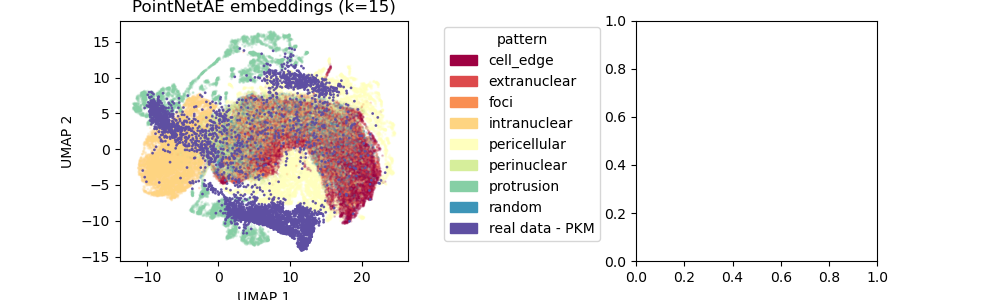

In [96]:
%matplotlib widget
plt.clf()
# plot_latent_space_v2(cnnAE_data.X, cnnAE_data.obs, 'pattern', 'Image-based AE', device)
# plot_latent_space(torch.Tensor(real_dataset.trans_coords.values), real_dataset.gene.to_dataframe(), 'cell_type', model, device)
plot_latent_space(train, train_dataset.coords['metadata'].to_dataframe(), 'pattern', model, device, plot_input=True, real_dataset=real_dataset, real_metadata_df_key='gene', real_metadata_df_category='PKM')

RF classification of latent dimensions

In [209]:
train_cell_ids = [metadata.split('_')[4] if metadata.split('_')[1]=='edge' else metadata.split('_')[3] for metadata in train_dataset.metadata.to_dataframe().iloc[:,0]]
train_indices_to_include = [i for i, cellid in enumerate(train_cell_ids) if cellid in ['icell' + str(i) for i in range(250)]]
exclude_cellids_train = train[train_indices_to_include]

test_cell_ids = [metadata.split('_')[4] if metadata.split('_')[1]=='edge' else metadata.split('_')[3] for metadata in test_dataset.metadata.to_dataframe().iloc[:,0]]
test_indices_to_include = [i for i, cellid in enumerate(test_cell_ids) if cellid in ['icell' + str(i) for i in range(250,318)]]
exclude_cellids_test = test[test_indices_to_include]

In [231]:
with torch.no_grad():
    train_embeddings = torch.Tensor()
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset=train[train_indices_to_include],
                                                batch_size=256,
                                                num_workers=2,
                                                shuffle=False,
                                                drop_last=False)
    for features in train_loader:
        encoded = model.encoding_fn(features.to(device))
        train_embeddings = torch.cat((train_embeddings, encoded.detach().cpu()))

    test_embeddings = torch.Tensor()
    model.eval()
    test_loader = torch.utils.data.DataLoader(dataset=test[test_indices_to_include],
                                                batch_size=256,
                                                num_workers=2,
                                                shuffle=False,
                                                drop_last=False)
    for features in test_loader:
            encoded = model.encoding_fn(features.to(device))
            test_embeddings = torch.cat((test_embeddings, encoded.detach().cpu()))

    real_embeddings = torch.Tensor()
    model.eval()
    real_data = torch.Tensor(real_dataset.trans_coords.values)
    realdata_loader = torch.utils.data.DataLoader(dataset=real_data,
                                                batch_size=256,
                                                num_workers=2,
                                                shuffle=False,
                                                drop_last=False)
    for features in realdata_loader:
        encoded = model.encoding_fn(features.to(device))
        real_embeddings = torch.cat((real_embeddings, encoded.detach().cpu()))

In [211]:
clf = RandomForestClassifier()
clf.fit(train_embeddings, train_dataset.pattern[train_indices_to_include])

RandomForestClassifier()

In [335]:
predictions = clf.predict(test_embeddings)
#test_dataset.pattern[test_indices_to_include]
scores = f1_score(test_dataset.pattern[test_indices_to_include], predictions, average='micro')
scores

0.6411116435074269

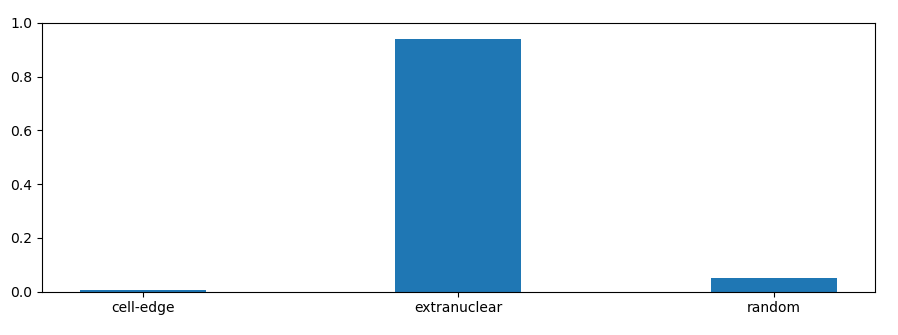

In [355]:
plt.clf()
predictions = clf.predict(real_embeddings[np.where(real_dataset.gene=='PKM')])
label, counts = np.unique(predictions, return_counts=True)
plt.bar(label,counts/counts.sum(),width=0.4)
plt.ylim(0,1)
plt.show()

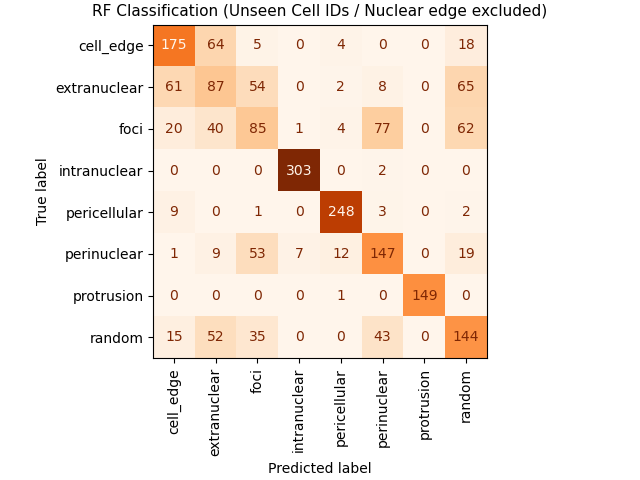

In [216]:
conf_mat = confusion_matrix(test_dataset.pattern[test_indices_to_include],predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                               display_labels=clf.classes_)
disp.plot(cmap='Oranges',xticks_rotation = 'vertical', colorbar=False)
disp.ax_.set_title('RF Classification (Unseen Cell IDs / Nuclear edge excluded)',fontsize=11)
disp.figure_.set_constrained_layout(True)
plt.show()

_________________________________________
BENCHMARKING AGAINST IMAGE-BASED NETWORK

In [344]:
conv_ae = anndata.read_h5ad('david_blurry_anndata_all_patterns.h5ad')
conv_ae.obs['cell_id'] = conv_ae.obs['corresponding_dapis'].str.split('_',expand=True).iloc[:,9]
conv_ae_reduced = conv_ae.obs.loc[:, ~conv_ae.obs.columns.isin(['rotation','rotation_interval','corresponding_dapis','original_image_paths'])].drop_duplicates()

In [345]:
train_indices_to_include = conv_ae_reduced[conv_ae_reduced['cell_id'].isin(['icell' + str(i) for i in range(250)])].index
test_indices_to_include = conv_ae_reduced[conv_ae_reduced['cell_id'].isin(['icell' + str(i) for i in range(250,318)])].index

In [346]:
# test_indices = np.random.choice(conv_ae_reduced.index,10000,replace=False)
# train_indices = np.setdiff1d(conv_ae_reduced.index, test_indices)
conv_ae_test_set = conv_ae[test_indices_to_include]
conv_ae_train_set = conv_ae[train_indices_to_include]

In [347]:
clf = RandomForestClassifier()
clf.fit(conv_ae_train_set.X, conv_ae_train_set.obs.pattern)

RandomForestClassifier()

In [348]:
predictions = clf.predict(conv_ae_test_set.X)
scores = f1_score(conv_ae_test_set.obs.pattern, predictions, average='micro')
scores

0.9315513626834382

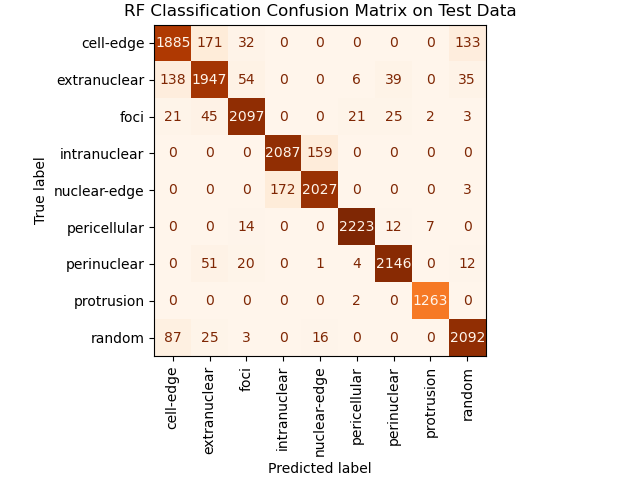

In [57]:
conf_mat = confusion_matrix(conv_ae_test_set.obs.pattern,predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                               display_labels=clf.classes_)
disp.plot(cmap='Oranges',xticks_rotation = 'vertical', colorbar=False)
disp.ax_.set_title('RF Classification Confusion Matrix on Test Data')
disp.figure_.set_constrained_layout(True)
plt.show()